In [228]:
from svg2data import svg2data
from svg.path import parse_path
import matplotlib.pyplot as plt
import mpld3
import math
import numpy as np
from scipy.spatial import cKDTree
#%matplotlib notebook
#%matplotlib inline

In [2]:
# axes: path578 (top, right), path570 (bottom), path556 (left)
#data = svg2data("edelweiss_ER_band_GGA3.svg")

In [3]:
path = parse_path('M 0,0 112.264,0 M 0,2.874 0,0 m 28.099,2.874 0,-2.874 m 28.033,2.874 0,-2.874 m 28.034,2.874 0,-2.874 m 28.098,2.874 0,-2.874')

In [4]:
path[1] #.end.imag #+ (2+2j)

Line(start=0j, end=(112.264+0j))

In [312]:
#from svgpathtools import svg2paths, wsvg
from svgpathtools import *
#paths, attributes = svg2paths('edelweiss_ER_band_GGA3.svg')
doc = Document('edelweiss_ER_band_GGA3.svg')
doc = doc.flatten_all_paths()

In [82]:
print (doc[0].path[0].start.real)
print(len(doc[0].path))
print (doc[0].path[0].length())

34.730800000000016
4
140.33000000000004


In [423]:
mpld3.enable_notebook()
# paths with 4 lines are error bars, bounding box
# paths with 10 are the bins, huh
# paths with 13 are the resolution curves
# path with 12 is the top/right axis with ticks
# paths wth 5 is left axis with ticks
# paths with 6 is bottom axis with ticks

def argand(doc):
    #import matplotlib.pyplot as plt
    #import numpy as np
    path_arr = []
    
    for result in doc:
        path = result.path

        if len(path) == 13: # maybe these are error bars?
            path_arr.append(path)
            #print (path)
            for line in path:
                # if the line is NOT a Bezier curve
                if not hasattr(line, 'control1'):
                    #print ("plotting, ", len(path))
                    #print(path)
                    plt.plot([line.start.real,line.end.real],[line.start.imag,line.end.imag],'ro-',label='python')
                    plt.ylim(0,200)
                    plt.xlim(0,200)
                    #break

    return path_arr

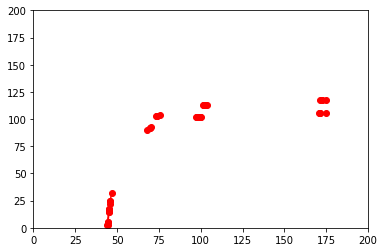

In [426]:
doc = Document('edelweiss_ER_band_GGA3.svg')
doc = doc.flatten_all_paths()

#print (plt.rcParams['interactive'])
mpld3.enable_notebook()
paths = argand(doc)

#argand(doc[6].path)

plt.show()
#print(len(paths)) #2 paths with 13 lines in edelweiss_ER_band_GGA3.svg

In [443]:
#paths[0].point(1)
x_arr = np.linspace(0,1,100)
path_arr = np.array([(paths[0].point(x).real, paths[0].point(x).imag) for x in x_arr])
path_arr_calib = np.array([(xcalib_fn(x), ycalib_fn(y) for (x,y) in path_arr])
print(path_arr[1:5,:])
plt.plot(path_arr[:,0], path_arr[:,1])
plt.show()

SyntaxError: invalid syntax (<ipython-input-443-86f502aa08d8>, line 4)

In [407]:
def get_dimensions(doc):
    ymin, ymax, xmin, xmax = 4*(np.NaN,)
    
    for element in doc:
        # first see if there's an axis
        # add it if it's not a duplicate
        path = element.path
        for line in path:
            x_arr = (line.start.real, line.end.real, xmin, xmax)
            y_arr = (line.start.imag, line.end.imag, ymin, ymax)
            
            xmin = np.nanmin(x_arr)
            xmax = np.nanmax(x_arr)
            ymin = np.nanmin(y_arr)
            ymax = np.nanmax(y_arr)
      
    print (xmin, xmax, ymin, ymax)
    return xmin, xmax, ymin, ymax

def get_axes(doc, width, height): # edited
    """send in individual paths,
    and also largest x and y value among all paths"""
    yaxes = []
    xaxes = []
    tol = 0.01
    
    for element in doc:
        # first see if there's an axis
        # add it if it's not a duplicate
        path = element.path
        for line in path:
            if math.isclose(line.length(), width, rel_tol=tol): 
                if (len(xaxes) < 1) or all(line != axis for axis in xaxes):
                    xaxes.append(line)
            elif math.isclose(line.length(), height, rel_tol=tol):
                if (len(yaxes) < 1) or all(line != axis for axis in yaxes):
                    yaxes.append(line)
    
    return (xaxes, yaxes)


def get_calib_points(doc, axes):
    yaxes, xaxes = axes
    calib_points = []
    
    for element in doc:
        # first see if there's an axis
        # if not, return
        path = element.path
        for line in path:
            # first see if it's a tick mark on the x-axis
            # test if it's vertical
            isVertical = math.isclose(line.start.real, line.end.real)
            # test if the starting y-coordinate is on any xaxis
            # can use axis.start.imag or axis.end.imag interchangeably
            isStartOnAxis = any(math.isclose(line.start.imag, axis.start.imag) for axis in xaxes)
            # test if the end y-coordinate is on any xaxis
            # can use axis.start.imag or axis.end.imag interchangeably
            isEndOnAxis = any(math.isclose(line.end.imag, axis.start.imag) for axis in xaxes)
            # test if the line is short
            isShort = line.length() < yaxes[0].length()/10
            
            if isVertical and (isStartOnAxis or isEndOnAxis) and isShort:
                if isStartOnAxis:
                    calib_points.append((line.start.real, line.start.imag))
                elif isEndOnAxis:
                    calib_points.append((line.start.real, line.end.imag))
                    
            # now see if it's a tick mark on the y-axis
            # test if it's horizontal
            isHorizontal = math.isclose(line.start.imag, line.end.imag)
            # test if the starting x-coordinate is on any yaxis
            # can use axis.start.real or axis.end.real interchangeably
            isStartOnAxis = any(math.isclose(line.start.real, axis.start.real) for axis in yaxes)
            # test if the end y-coordinate is on any xaxis
            # can use axis.start.imag or axis.end.imag interchangeably
            isEndOnAxis = any(math.isclose(line.end.real, axis.start.real) for axis in yaxes)
            # test if the line is short
            isShort = line.length() < xaxes[0].length()/10
            
            if isHorizontal and (isStartOnAxis or isEndOnAxis) and isShort:
                if isStartOnAxis:
                    calib_points.append((line.start.real, line.start.imag))
                elif isEndOnAxis:
                    calib_points.append((line.end.real, line.start.imag))
    
    # call set to get rid of non-unique points
    return (list(set(calib_points)))
    
def calib(user_points, svg_points):
    xmin_user, ymin_user = np.amin(user_points, axis=0)
    
    # min returns ymax_svg because of the svg coordinate system
    xmin_svg, ymax_svg = np.amin(svg_points, axis=0)
    xmax_svg, ymin_svg = np.amax(svg_points, axis=0)

    # get the x-values from the svg file and user
    xcalib_svg = svg_points[np.isclose(svg_points[:,1], ymin_svg)][:,0]
    xcalib_user = user_points[np.isclose(user_points[:,1], ymin_user)][:,0]
    # make the values unique
    xcalib_svg = list(set(xcalib_svg))
    xcalib_user = list(set(xcalib_user))
    # sort the list in-place
    xcalib_svg.sort()
    xcalib_user.sort()
    #print(xcalib_svg, xcalib_user)
    xcalib_fn = get_calib_func(xcalib_user, xcalib_svg)
    
    # get the y-values from the svg file and user
    ycalib_svg = svg_points[np.isclose(svg_points[:,0], xmin_svg)][:,1]
    ycalib_user = user_points[np.isclose(user_points[:,0], xmin_user)][:,1]
    # make the values unique
    ycalib_svg = list(set(ycalib_svg))
    ycalib_user = list(set(ycalib_user))
    # sort the list in-place
    # note that because of svg coordinate system, small user value goes with large svg value
    ycalib_svg.sort(reverse=True)
    ycalib_user.sort()
    #print(ycalib_svg, ycalib_user)
    ycalib_fn = get_calib_func(ycalib_user, ycalib_svg)
    
    return xcalib_fn, ycalib_fn
    
    
def get_calib_func(user_arr, svg_arr):
    # save this for when there are actually double-calib points 
    # will choose the best fit
    svg_arr_list = []
    
    if len(user_arr) != len(svg_arr):
        r = np.average(np.diff(svg_arr))/2
        svg_arr_points = np.ones((len(svg_arr),2))
        svg_arr_points[:,0] = svg_arr[:]

        tree = cKDTree(svg_arr_points)
        rows_to_fuse = tree.query_pairs(r=r,output_type='ndarray') 
        for idx in rows_to_fuse.flatten():
            #print(idx)
            svg_arr_list.append(np.delete(svg_arr, idx))
    
    else:
        svg_arr_list.append(svg_arr)
        
    # fit a linear function to the arrays
    fit_goodness = []
    fit_arr = []
    for svg_arr in svg_arr_list:
        fit, res, rank, sing, thresh = np.polyfit(svg_arr,user_arr, 1, full=True)
        #print("res: ", res)
        fit_goodness.append(res)
        fit_arr.append(np.poly1d(fit))
        
    min_idx = np.argmin(fit_goodness)
    fit_fn = fit_arr[min_idx]
        
    if False:
        plt.plot(svg_arr_list[min_idx], user_arr,'o')
        plt.plot(svg_arr_list[min_idx], fit_fn(svg_arr_list[min_idx]),'+')
        plt.show()
        
    return fit_fn
        

In [409]:
doc = Document('edelweiss_ER_band_GGA3.svg')
doc = doc.flatten_all_paths()

xmin, xmax, ymin, ymax = get_dimensions(doc)

height = xmax - xmin
width = ymax - ymin
#height = 147.37939999999998 - 2.5768999999999664
#width = 175.0608 - 34.730800000000016



xaxes, yaxes = get_axes(doc, width, height)
#print (xaxes, yaxes)
#print (xaxes[1] == xaxes[2].reversed())
#print (yaxes[0].reversed())

svg_calibPoints = np.array(get_calib_points(doc, (xaxes, yaxes)))
print(svg_calibPoints)

graph_points = np.array([(0,0), (50,0), (100,0), (150,0), (200,0), (0,0.05), (0,0.1), (0,0.15)])
#print (graph_points)
#xmin, ymin = np.amin(graph_points, axis=0)
xcalib_fn, ycalib_fn = calib(graph_points, svg_calibPoints)
print(xcalib_fn(54.4), ycalib_fn(64.4))
print(xcalib_fn(68.8), ycalib_fn(86))


34.73079000000004 175.06081 1.6618999999999744 147.37939999999998
[[ 34.7308  147.3794 ]
 [104.89579   2.5769 ]
 [175.06079   2.5769 ]
 [ 34.7308   50.8719 ]
 [175.06079  99.0844 ]
 [139.93829   2.5769 ]
 [ 69.85455 147.3794 ]
 [104.8958  147.3794 ]
 [ 34.7308    2.5769 ]
 [ 34.7308   99.0844 ]
 [175.06079  50.8719 ]
 [ 34.73079   2.5769 ]
 [175.06079 147.3794 ]
 [ 69.85454   2.5769 ]
 [139.9383  147.3794 ]
 [175.0608  147.3794 ]]
28.01576643933936 0.08595908661429012
48.54357018496147 0.06358123501749227


In [6]:
idx = 5
print(paths[idx], attributes[idx])

print("path is continuous? ", paths[idx].iscontinuous())
print("path is closed? ", paths[idx].isclosed())

Path(CubicBezier(start=0j, control1=0.407j, control2=(-0.328+0.736j), end=(-0.733+0.736j)),
     CubicBezier(start=(-0.733+0.736j), control1=(-1.138+0.736j), control2=(-1.468+0.407j), end=(-1.468+0j)),
     CubicBezier(start=(-1.468+0j), control1=(-1.468-0.404j), control2=(-1.138-0.733j), end=(-0.733-0.733j)),
     CubicBezier(start=(-0.733-0.733j), control1=(-0.328-0.733j), control2=-0.404j, end=0j)) {'id': 'path586', 'style': 'fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:none', 'inkscape:connector-curvature': '0', 'd': 'm 0,0 c 0,0.407 -0.328,0.736 -0.733,0.736 -0.405,0 -0.735,-0.329 -0.735,-0.736 0,-0.404 0.33,-0.733 0.735,-0.733 C -0.328,-0.733 0,-0.404 0,0'}
path is continuous?  True
path is closed?  True


In [ ]:
#paths[idx].isclosed()
